In [1]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
import warnings
import sys
sys.path.insert(0, '..')
from src.metric.metric import calculate_metric

warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

**Toxic Word Classifier**

roberta-base pre-trained on Jigsaw Unintended Bias in Toxicity Classification


In [2]:
from detoxify import Detoxify
classificator = Detoxify('unbiased')
results = classificator.predict(['example text 1','G...! What the fuck?'])
results['toxicity']

[0.0004102117964066565, 0.974835991859436]

**Paraphraser model**

PEGASUS or Pre-training with Extracted Gap-sentences for Abstractive SUmmarization Sequence-to-sequence models, fine-tuned for paraphrasing. It uses self-supervised objective Gap Sentences Generation (GSG) to train a transformer encoder-decoder model. 

In [3]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
model_name = 'tuner007/pegasus_paraphrase'

tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

def get_response(input_text, num_return_sequences=5,num_beams=5):
  batch = tokenizer(input_text,truncation=True,padding='longest', return_tensors="pt").to(device)
  translated = model.generate(**batch, num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text


In [3]:
def paraphraser(batch_sentence : list, batch_size: int, num_beams=5, num_return_sequences=5) -> list:
    """
    Paraphrase a batch of sentences using a transformer-based model and select the least toxic paraphrase.

    Args:
        batch_sentence (list): A list of sentences to be paraphrased.
        batch_size (int): The number of sentences in the batch.
        num_beams (int): The number of beams for paraphrasing (default is 5).
        num_return_sequences (int): The number of paraphrase sequences to return (default is 5).

    Returns:
        list: A list of the best paraphrased sentences with the least toxicity.

    Note:
    This function uses a transformer-based model to generate multiple paraphrased versions of the input sentences.
    It then predicts the toxicity of each paraphrase and selects the least toxic one for each input sentence.

    """
    paraphrased_variants = get_response(batch_sentence, num_beams=num_beams, num_return_sequences=num_return_sequences)
    toxicity = classificator.predict(paraphrased_variants)['toxicity']
    
    best_paraphrased = []

    for batch_start in range(batch_size):
        left, right = batch_start * num_return_sequences,  (batch_start + 1) * num_return_sequences

        ind = np.argmin(toxicity[left: right])
        best_paraphrased.append(paraphrased_variants[left : right][ind])

    return best_paraphrased


In [5]:
from src.data.make_dataset import FilteredDataset
from torch.utils.data import DataLoader

batch_size = 16
test_dataset = FilteredDataset(test=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

In [6]:
for batch, label in test_dataloader:
    detoxified = paraphraser(batch, batch_size)
    for original, detox in zip(batch, detoxified):
        print(f'Original:{original}')
        print(f'Detoxified:{detox}')
    break

Original:Hot chicks are starfuckers in Coeur d'Alene.
Detoxified:There are hot chick in Coeur d'Alene.
Original:Oh, Grace, don't be ridiculous.
Detoxified:Grace, don't be crazy.
Original:Two... - Fuck yo sister.
Detoxified:Two...
Original:Next time you decide to take a bath, Private, let me know, or I'll kick your ass,
Detoxified:Next time you decide to take a bath, Private, let me know, or I'll kick your ass.
Original:I finally caught you, you dirty--
Detoxified:I finally caught you.
Original:God, diarrhoea like thatmust be Anti-Hippocratic.
Detoxified:It is Anti-Hippocratic to have diarrhoea like that.
Original:You're a liar. - And I love you for it.
Detoxified:I love you for lying.
Original:'I don't need to look at that rubbish, I know it all.'
Detoxified:I know what I'm talking about, so I don't need to look at it.
Original:You know You bitch and you complain and you tell me these things.
Detoxified:You complain and you tell me these things.
Original:I'm so damned disappointed.
Det

In previous we classified and paraphrased each word in sentence, now the model, since it seq2seq, it allows us to paraphrased any number of words in sentence, so let’s introduce hyperparameter n - number of words in one token

In [4]:
#n-hyperparameter
#n-word tokenizer
from typing import Union

def n_word_tokenizer(sentences: Union[str, list], n=2):
    """
    Tokenize input sentences into n-word chunks using a specified value of n.

    Args:
        sentences (Union[str, list]): A single sentence or a list of sentences to tokenize.
        n (int, optional): The number of words in each chunk (default is 2).

    Returns:
        list: A list of tokenized sentences, where each sentence is divided into n-word chunks.

    Note:
    This function takes input sentences and tokenizes them into chunks of n words each. It can accept
    either a single sentence as a string or a list of sentences. If a single sentence is provided, it is
    treated as a batch of one sentence.
    """
    if isinstance(sentences, str):
        sentences = [sentences]

    batch = []
    for sentence in sentences:
        splitted = sentence.split()
        slices = [splitted[i * n: i * n + n] for i in range((len(splitted)  + n - 1)// n)]
        n_sentence = [' '.join(part) for part in slices]
        batch.append(n_sentence)
    return batch

In [8]:
n_word_tokenizer('n_word tokenizer split the sentence into list, where len of each element is <= n', n=2)

[['n_word tokenizer',
  'split the',
  'sentence into',
  'list, where',
  'len of',
  'each element',
  'is <=',
  'n']]

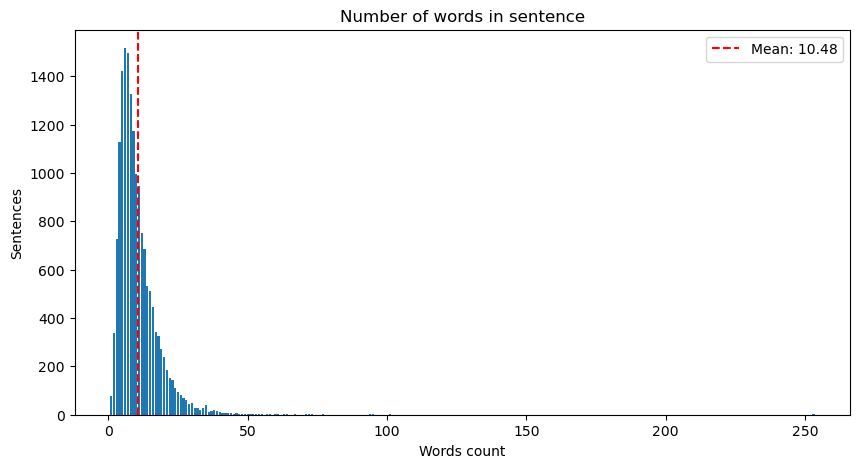

In [9]:
import matplotlib.pyplot as plt
import numpy as np

X = np.concatenate([batch for batch, _ in test_dataloader])

lens = list(map(lambda x: len(x.split()), X))
unique_lens, cnt = np.unique(lens, return_counts=True)


mean = np.sum(unique_lens * cnt) / np.sum(cnt)

plt.figure(figsize=(10, 5))
plt.bar(unique_lens, cnt)

plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.title('Number of words in sentence')
plt.xlabel('Words count')
plt.ylabel('Sentences')
plt.legend()
plt.show()


**Gridsearch of n**

let's take 1000 examples due to lack of perfomance and trying to figure out the best n

In [10]:
from torch.utils.data import Subset

N_samples = 1000
num_return_sequences = 2
batch_size = 4
subset_dataset = Subset(test_dataset, np.arange(N_samples))
subset_loader = DataLoader(subset_dataset, batch_size=batch_size)


Since the number of words in average is 10, so let's grid search n until the half of sentence and take to consideration also the whole sentence

In [11]:
max_number_of_words = max(lens)
n_params = [2, 3, 4, 5, max_number_of_words]
dict_metrics = {'ACC': [], 'SIM': [], 'FL': [], 'J': [], 'BLUE':[]}

for n in tqdm(n_params):
    outputs = []
    target = []

    for batch, y_true in subset_loader:
        tokenized = n_word_tokenizer(batch, n)
        offset = [len(x) for x in tokenized]
        offset = [sum(offset[:i]) for i in range(len(offset) + 1)]
        tokenized = np.concatenate(tokenized)
        paraphrased = paraphraser(list(tokenized), len(tokenized))
        collected_batch = [' '.join(paraphrased[offset[i]: offset[i + 1]]) for i in range(len(offset) - 1)]
        
        outputs += collected_batch
        target += y_true
    
    metrics = calculate_metric(target, outputs)
    for key in metrics:
        dict_metrics[key].append(metrics[key])



  0%|          | 0/5 [00:00<?, ?it/s]

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 32/32 [00:00<00:00, 83.90it/s]


Calculating CoLA acceptability stats


 20%|██        | 1/5 [06:59<27:58, 419.55s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.7250|0.5518|0.4429|0.1766|0.2614|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 32/32 [00:01<00:00, 16.56it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 32/32 [00:00<00:00, 107.14it/s]


Calculating CoLA acceptability stats


 40%|████      | 2/5 [11:39<16:52, 337.36s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.7530|0.5880|0.5915|0.2636|0.3195|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 32/32 [00:03<00:00,  8.64it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 32/32 [00:00<00:00, 126.23it/s]


Calculating CoLA acceptability stats


 60%|██████    | 3/5 [16:50<10:50, 325.29s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.7640|0.6146|0.6671|0.3124|0.3579|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 32/32 [00:01<00:00, 16.11it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 32/32 [00:00<00:00, 127.38it/s]


Calculating CoLA acceptability stats


 80%|████████  | 4/5 [21:00<04:55, 295.58s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.7510|0.6183|0.7336|0.3471|0.3838|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 32/32 [00:01<00:00, 29.58it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 32/32 [00:00<00:00, 147.45it/s]


Calculating CoLA acceptability stats


100%|██████████| 5/5 [24:38<00:00, 295.72s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.7660|0.6542|0.9302|0.4696|0.4303|



In [14]:
dict_metrics

{'ACC': [0.725, 0.753, 0.764, 0.751, 0.766],
 'SIM': [0.551764698151499,
  0.5880206808894872,
  0.6145981463659554,
  0.6183480717912316,
  0.6541988720968366],
 'FL': [0.44287023024912925,
  0.5914560647010804,
  0.667122672945261,
  0.733566449037753,
  0.9301836207006127],
 'J': [0.17660851112941753,
  0.2636181540822002,
  0.31237335675173555,
  0.3471257049960368,
  0.4696395470833589],
 'BLUE': [0.2613636579492054,
  0.3195059743053478,
  0.35786435167422864,
  0.3837725397988029,
  0.43032997251627525]}

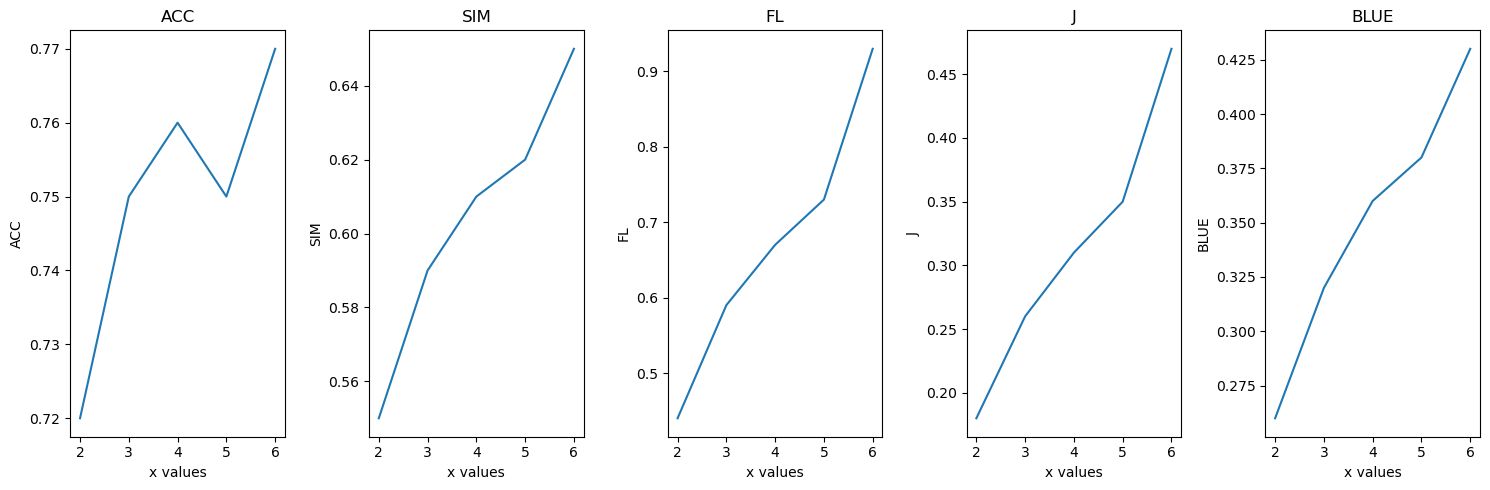

In [15]:
fig, axs = plt.subplots(1, len(dict_metrics), figsize=(15, 5))
x = [2, 3, 4, 5, 6]
#6 - the whole sentence
for i, (metric, values) in enumerate(dict_metrics.items()):
    axs[i].plot(x, np.round(values, 2))
    axs[i].set_title(metric)
    axs[i].set_xlabel('x values')
    axs[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

As we can see, with the increase of n - metrics increases, so for the future we will use only whole sentence

In [11]:
outputs = []
target = []

for batch, y_true in tqdm(test_dataloader):
    paraphrased = paraphraser(batch, batch_size) 
    outputs.extend(paraphrased)
    target.extend(y_true)

predictions_hypothesis1 = pd.DataFrame({'Predictions': outputs})
predictions_hypothesis1.to_csv('../data/interim/hypothesis1_predictions.csv')

100%|██████████| 1034/1034 [51:58<00:00,  3.02s/it] 


In [12]:
predictions_hypothesis1 = pd.read_csv('../data/interim/hypothesis1_predictions.csv', index_col=0)
predictions_hypothesis1 = list(predictions_hypothesis1['Predictions'].values)
predictions_hypothesis1[:5]

["There are hot chick in Coeur d'Alene.",
 "Grace, don't be crazy.",
 'Two...',
 "Next time you decide to take a bath, Private, let me know, or I'll kick your ass.",
 'I finally caught you.']

In [13]:
calculate_metric(target, predictions_hypothesis1)

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 517/517 [00:25<00:00, 20.42it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 517/517 [00:03<00:00, 150.06it/s]


Calculating CoLA acceptability stats


100%|██████████| 517/517 [01:01<00:00,  8.37it/s]


| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.7569|0.6511|0.9333|0.4640|0.4248|



{'ACC': 0.7568907156673114,
 'SIM': 0.6511195927311573,
 'FL': 0.9333203696437847,
 'J': 0.4639579122112243,
 'BLUE': 0.4248203542470307}